Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000295542s, CPU 0.000462s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00351221s, CPU 0.003488s)
Info    : 207 nodes 414 elements


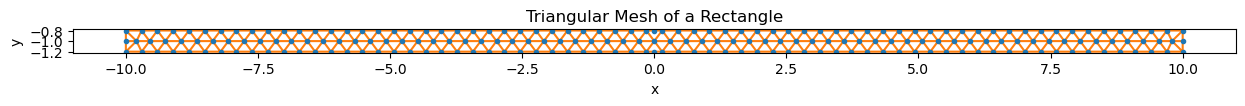

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import bemcs
import warnings
import gmsh

warnings.filterwarnings("ignore")


# function to create mesh
def create_mesh(Lscale, bimaterial_depth, meshsize=0.4):
    # construct a triangle mesh (with thickness = 0.2 units)
    box = np.array(
        [
            [-Lscale, bimaterial_depth * 1.2],
            [-Lscale, bimaterial_depth * 0.8],
            [Lscale, bimaterial_depth * 0.8],
            [Lscale, bimaterial_depth * 1.2],
        ]
    )

    # Initialize the gmsh API
    gmsh.initialize()

    # Create a new model
    gmsh.model.add("rectangle")

    # Define the rectangle vertices
    p1 = gmsh.model.geo.addPoint(box[0, 0], box[0, 1], 0)  # BL
    p2 = gmsh.model.geo.addPoint(box[1, 0], box[1, 1], 0)  # TL
    p3 = gmsh.model.geo.addPoint(box[2, 0], box[2, 1], 0)  # TR
    p4 = gmsh.model.geo.addPoint(box[3, 0], box[3, 1], 0)  # BR
    p5 = gmsh.model.geo.addPoint(0.0, box[0, 1], 0)  # CB
    p6 = gmsh.model.geo.addPoint(0.0, box[1, 1], 0)  # CT

    # Define the lines
    # l1 = gmsh.model.geo.addLine(p5, p4)
    # l2 = gmsh.model.geo.addLine(p4, p3)
    # l3 = gmsh.model.geo.addLine(p3, p6)
    # l4 = gmsh.model.geo.addLine(p6, p5)
    # l5 = gmsh.model.geo.addLine(p5, p1)
    # l6 = gmsh.model.geo.addLine(p1, p2)
    # l7 = gmsh.model.geo.addLine(p2, p6)
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Define the curve loop and plane surface
    curve_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    plane_surface = gmsh.model.geo.addPlaneSurface([curve_loop])

    # Synchronize to create the surface
    gmsh.model.geo.synchronize()

    # Define the mesh generation options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Delaunay
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.1)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", meshsize)

    # Generate the 2D mesh
    gmsh.model.mesh.generate(2)

    # Extract the nodes and elements
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    node_coords = node_coords.reshape(-1, 3)[:, :2]  # Only take x and y coordinates

    element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements(tag=2)
    triangles = (
        element_node_tags[1].reshape(-1, 3) - 1
    )  # Convert to zero-based indexing
    # gmsh.model.mesh
    # Finalize the gmsh API
    gmsh.finalize()

    Ntri = len(triangles[:, 0])

    xm = np.zeros((Ntri, 1))
    ym = np.zeros((Ntri, 1))
    for i in range(0, Ntri):
        xm[i] = np.mean(node_coords[triangles[i, :], 0])
        ym[i] = np.mean(node_coords[triangles[i, :], 1])

    return node_coords, triangles, xm, ym


# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
bimaterial_depth = -1.0
mu_deep = 2.0
mu_shallow = 1.0

els_source = bemcs.initialize_els()
els = bemcs.initialize_els()
els_topo = bemcs.initialize_els()

# setup a fault geometry (source) - in this case it is a semi-infinite strike-slip fault
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.0])
els_source.x2 = np.array([0])
els_source.y2 = np.array([-1.5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# construct triangle mesh
node_coords, triangles, xm, ym = create_mesh(Lscale, bimaterial_depth, meshsize=0.3)
# store centroids of each triangle
Ntri = len(triangles[:, 0])


# Plot the mesh
plt.figure(figsize=(15, 5))
plt.plot(node_coords[:, 0], node_coords[:, 1], ".")
plt.triplot(node_coords[:, 0], node_coords[:, 1], triangles)
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Triangular Mesh of a Rectangle")
plt.show()

In [7]:
# Construct stress kernels for triangle elements

K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xm, ym, els_source, mu
)
quadcoefs = bemcs.phicoef(np.array([-1.0, 0, 1.0]), np.array([1.0, 1.0, 0]), a=1.0)
# quadcoefs = np.array([1, 1, 1])

# compute grad(u) due to source at els
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
# dudx0 = K_sx @ quadcoefs
dudy0 = K_sy @ quadcoefs

# triangle kernels
K_tsx = np.zeros((Ntri, Ntri))
K_tsy = np.zeros_like(K_tsx)
for i in range(0, Ntri):
    tricoords = np.vstack(
        [node_coords[triangles[i, :], 0], node_coords[triangles[i, :], 1]]
    ).T
    _, sx, sy = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
        tricoords, xm.flatten(), ym.flatten(), fval=1.0, mu=mu
    )
    K_tsx[:, i] = sx
    K_tsy[:, i] = sy

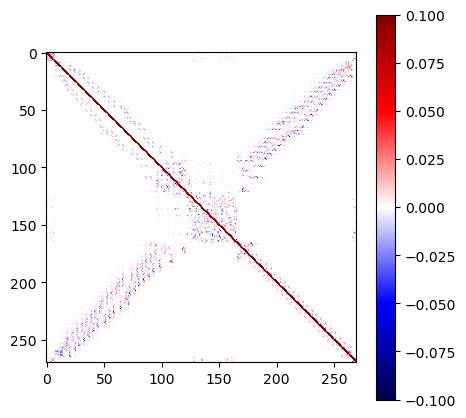

Condition number of system: 1.064112251400235


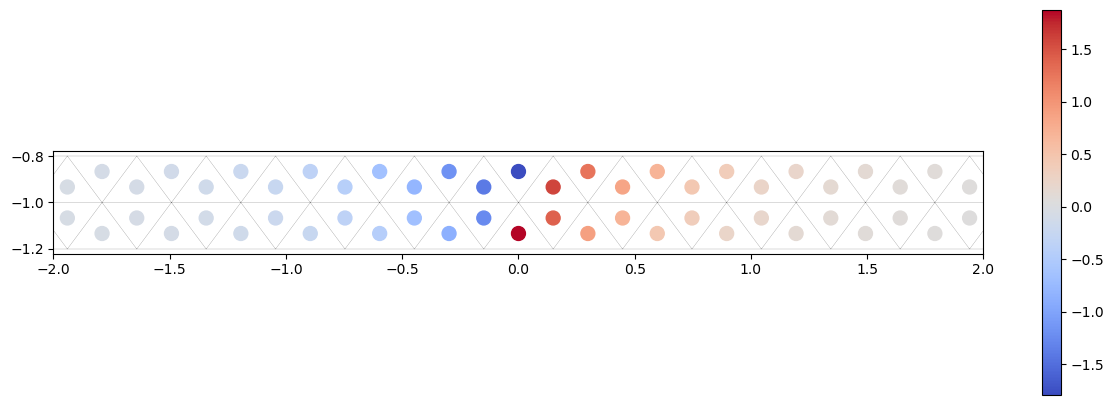

In [8]:
# mu_deep = 5.0
# mu_shallow = 1.0
deltay = np.max(node_coords[:, 1]) - np.min(node_coords[:, 1])
muval = (ym - np.min(node_coords[:, 1])) / deltay * (mu_shallow - mu_deep) + mu_deep
betavec = -1 / muval * (mu_shallow - mu_deep) / deltay

kernel = np.eye(Ntri) - np.tile(betavec, (1, Ntri)) * K_tsy

plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

# construct vector for RHS (we only use dudy for the source term because of flat topo)
rhsvec = betavec.flatten() * dudy0

print("Condition number of system: " + str(np.linalg.cond(kernel)))
solvec_tri = np.linalg.inv(kernel) @ rhsvec

plt.figure(figsize=(15, 5))
plt.triplot(node_coords[:, 0], node_coords[:, 1], triangles, "k-", linewidth=0.1)
plt.scatter(xm, ym, 100, solvec_tri, cmap="coolwarm")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-2, 2])
plt.show()

In [9]:
# plot resulting displacement field
nx_obs = 50
ny_obs = 50
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

Ksx0, Ksy0, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)

# triangle kernels
K_tu = np.zeros((len(xo), Ntri))
K_tsx = np.zeros((len(xo), Ntri))
K_tsy = np.zeros((len(xo), Ntri))

for i in range(0, Ntri):
    tricoords = np.vstack(
        [node_coords[triangles[i, :], 0], node_coords[triangles[i, :], 1]]
    ).T
    u, sx, sy = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
        tricoords, xo.flatten(), yo.flatten(), fval=1.0, mu=mu
    )
    K_tu[:, i] = u
    K_tsx[:, i] = sx
    K_tsy[:, i] = sy

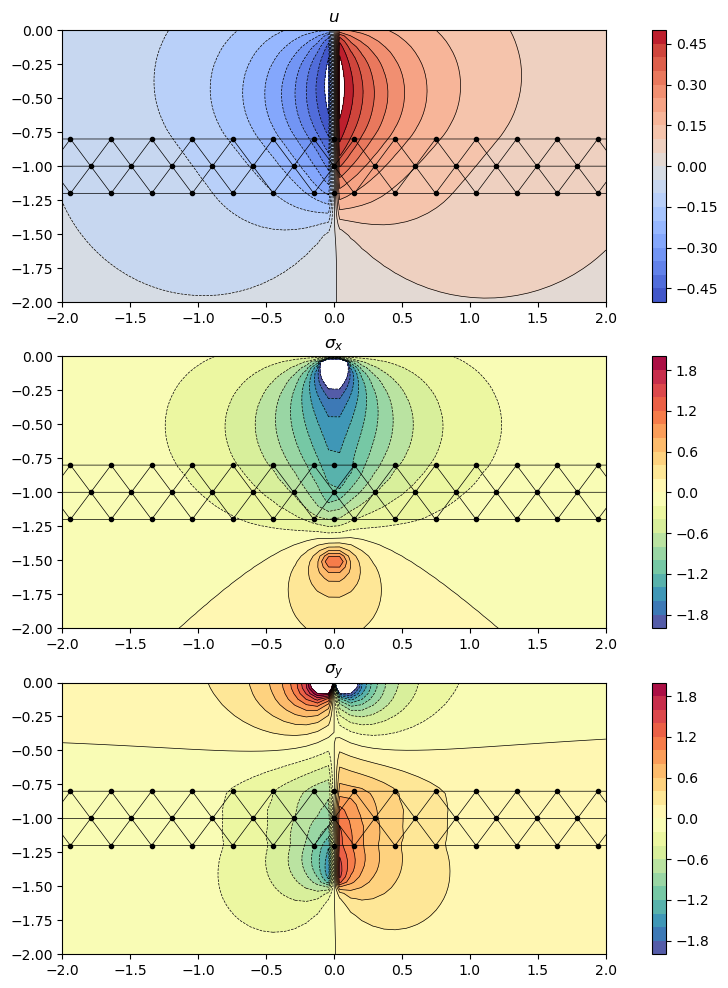

In [10]:
# compute displacements
u = K_tu @ solvec_tri.reshape(-1, 1) + Ku0 @ quadcoefs.reshape(-1, 1)

sx = K_tsx @ solvec_tri.reshape(-1, 1) + Ksx0 @ quadcoefs.reshape(-1, 1)

sy = K_tsy @ solvec_tri.reshape(-1, 1) + Ksy0 @ quadcoefs.reshape(-1, 1)

plt.figure(figsize=(12, 12))
for i in range(0, 3):
    plt.subplot(3, 1, i + 1)
    if i == 0:
        toplot = u.reshape(ny_obs, nx_obs)
        maxval = 0.5
        cmap = "coolwarm"
    elif i == 1:
        toplot = sx.reshape(ny_obs, nx_obs)
        maxval = 2.0
        cmap = "Spectral_r"
    else:
        toplot = sy.reshape(ny_obs, nx_obs)
        maxval = 2.0
        cmap = "Spectral_r"
    minval = -maxval
    levels = np.linspace(minval, maxval, 21)
    plt.contourf(
        xo.reshape(ny_obs, nx_obs),
        yo.reshape(ny_obs, nx_obs),
        toplot,
        cmap=cmap,
        vmin=minval,
        vmax=maxval,
        levels=levels,
    )
    plt.colorbar()
    plt.triplot(node_coords[:, 0], node_coords[:, 1], triangles, "k.-", linewidth=0.5)
    plt.contour(
        xo.reshape(ny_obs, nx_obs),
        yo.reshape(ny_obs, nx_obs),
        toplot,
        colors="k",
        levels=levels,
        linewidths=0.5,
    )

    plt.xlim([-2, 2])
    plt.ylim([-2, 0])
    plt.clim([minval, maxval])
    if i == 0:
        plt.title("$u$")
    elif i == 1:
        plt.title("$\sigma_x$")
    else:
        plt.title("$\sigma_y$")
    plt.gca().set_aspect("equal", adjustable="box")
plt.show()